In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# General imports
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

In [30]:
# HyperbolicTSNE imports
from hyperbolicTSNE import Datasets, load_data
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, save_experiment_results,  next_experiment_folder_id
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import plot_poincare, plot_tree

# Data generation function
from data_gen import generate_Tree_D, generate_Tree_V

# Storing results functions
from hyperbolicTSNE.util import GaussianKL_Tree_results, HyperbolicKL_Tree_results

# Custom Hierarchical D, V 

Generate distance D, affinity V matrices based on a tree-like hierarchy

In [31]:
# Data generation parameters
cluster_size = 10
dist = 5
n_children = 4
depth = 3
n_nodes = sum(np.power(n_children, d) for d in range(depth + 1))

# Sample parameters
mu = 0
# sigma = np.sqrt(dist / n_children)       # std sigma
sigma = np.sqrt(dist)

# D, V matrix
D = generate_Tree_D(cluster_size, n_children, n_nodes, mu, sigma, dist)
V = generate_Tree_V(D, mean=mu, var=np.square(sigma))                       # Also known as P_ij Matrix

# Datalabels := [label node 0, label node 1, ... label node n_nodes]
dataLabels = np.array([[label for _ in range(cluster_size)] for label in range(n_nodes)]).flatten()
print("dataLabels shape: ", dataLabels.shape)

# print(V[0])
# print(D[0])

# Sanity check
print("is D symmetric? ", np.allclose(D, D.T))
print("is V symmetric? ", np.allclose(V, V.T))
print("D shape: ", D.shape)

# Turn V into a csr matrix (so it works with hyperbolicKL cf)
V = csr_matrix(V)

print(f"V[0] max: {np.max(V[0])}, V[0] min: {np.min(V[0])}")
print(V[0].toarray())

dataLabels shape:  (850,)
is D symmetric?  True
is V symmetric?  True
D shape:  (850, 850)
V[0] max: 0.00018277955541954645, V[0] min: 0.0
[[0.00000000e+00 1.75360296e-04 1.58878303e-04 1.82779555e-04
  3.22084896e-05 1.04528240e-04 1.01169996e-04 1.16868100e-04
  9.64156950e-05 1.70325658e-04 6.29901955e-06 9.48861690e-06
  1.16827309e-06 1.88448812e-07 2.75421748e-06 1.50302553e-06
  6.93854382e-06 4.34418274e-07 4.60833733e-07 9.34373252e-06
  8.39236755e-06 9.87296945e-07 1.04580067e-07 9.29854610e-06
  1.19342219e-07 5.93599240e-06 9.13443019e-06 9.22256390e-08
  9.81882700e-08 4.62179317e-07 5.67435903e-06 1.07994741e-05
  2.17300413e-06 5.01376938e-07 6.13445480e-06 1.26496283e-06
  1.06167782e-05 4.78134917e-06 7.47918310e-06 1.11728091e-06
  2.12850878e-06 1.40210106e-05 8.75315106e-08 1.12530668e-05
  9.60547485e-08 3.55341488e-07 1.27902447e-07 6.12206486e-06
  3.56676053e-06 1.01002393e-05 2.35796116e-10 3.39262761e-09
  4.77259610e-13 6.72039059e-11 2.17274386e-09 3.411476

In [32]:
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"     # NOTE: We will manually calculate the gradients
data_home = "datasets"

experiments_folder = "./experiment_results/"
exp_id = next_experiment_folder_id(experiments_folder)

seed = 42
correct_gradient = [True, False]                   # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = [True]                               # NOTE: Exact computation or BH estimation of gradient
grad_scale_fix = True                        # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                             # Note that the correct hyperoblic gradient has an inverse metric tensor factor
cfs = [HyperbolicKL]

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 1000
main_iterations = 50000

Compute hyperbolic variance

In [33]:
def hyp_dist(a, b):
        num = (a-b) * (a-b)
        denum = (1 - a*a) * (1 - b*b)
        return np.arccosh(1 + 2 * (num / denum))

# Computing hyperbolic variance using a heuristic method
max_dist = np.max(D)                                    # max distance between 2 datapoints in high dim. space
size_tol = 0.999
max_dist_H = hyp_dist(-size_tol, size_tol)              # the max width we want to adhere to in hyperbolic embeddings
hyp_sigma = (max_dist_H / max_dist) * sigma             # sigma computed in above cell
hyp_var = np.square(hyp_sigma)

print(f"scaling sigma first - hyp sigma:{hyp_sigma}, hyp var:{hyp_var}")

# Second method for computing hyperoblic variance
# hyp_sigma = (1. / max_dist) * sigma

scaling sigma first - hyp sigma:0.5159433796695905, hyp var:0.2661975710248792


In [34]:
print(hyp_dist(-0.99, 0.99))
print(hyp_dist(-0.999, 0.999))
print(hyp_dist(-0.9999, 0.9999))
print(hyp_dist(-0.99999, -0.9999))

10.586609649448981
15.200804669000828
19.806875102572892
2.3026300942365725


In [35]:
from itertools import product

experiment_details = list(product(cfs, correct_gradient, exact))
print("nr. of experiments: ", len(experiment_details))

for exp in experiment_details:
    print(exp)

nr. of experiments:  2
(<class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, True, True)
(<class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, False, True)


[Experiment: 97] 	 cf: HyperbolicKL, correct grad: True,  exact grad: True
The learning rate is: 0.7083333333333334
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.7083333333333334, 'learning_rate_main': 0.7083333333333334, 'exaggeration': 12, 'exaggeration_its': 1000, 'gradientDescent_its': 50000, 'vanilla': True, 'momentum_ex': 0.5, 'momentum': 0.2, 'exact': True, 'area_split': False, 'n_iter_check': 2000, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True, 'n_iter_without_progress': 17000.0, 'min_grad_norm': 1e-10}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 84.96612 grad_norm: 1.42072e-04: 100%|██████████| 1000/1000 [00:19<00:00, 50.89it/s]


[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.65888 grad_norm: 5.73836e-05:  38%|███▊      | 19000/50000 [05:57<09:42, 53.22it/s]


4
Animation being saved to: ./experiment_results/experiment_97//emb_anim.gif


Animating:   0%|          | 0/801 [00:00<?, ?it/s]/Users/haoranxia/Thesis-Delft/hyperbolic-tsne/hyperbolicTSNE/visualization.py:354: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=801.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 804it [00:23, 34.13it/s]                       


[Experiment: 98] 	 cf: HyperbolicKL, correct grad: False,  exact grad: True
The learning rate is: 0.7083333333333334
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.7083333333333334, 'learning_rate_main': 0.7083333333333334, 'exaggeration': 12, 'exaggeration_its': 1000, 'gradientDescent_its': 50000, 'vanilla': True, 'momentum_ex': 0.5, 'momentum': 0.2, 'exact': True, 'area_split': False, 'n_iter_check': 2000, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': False, 'n_iter_without_progress': 17000.0, 'min_grad_norm': 1e-10}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 84.96612 grad_norm: 1.42072e-04: 100%|██████████| 1000/1000 [00:17<00:00, 56.00it/s]


[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.65888 grad_norm: 5.73836e-05:  38%|███▊      | 19000/50000 [06:20<10:20, 49.94it/s]


4
Animation being saved to: ./experiment_results/experiment_98//emb_anim.gif


Animating:   0%|          | 0/801 [00:00<?, ?it/s]/Users/haoranxia/Thesis-Delft/hyperbolic-tsne/hyperbolicTSNE/visualization.py:354: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=801.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 804it [00:24, 33.45it/s]                       


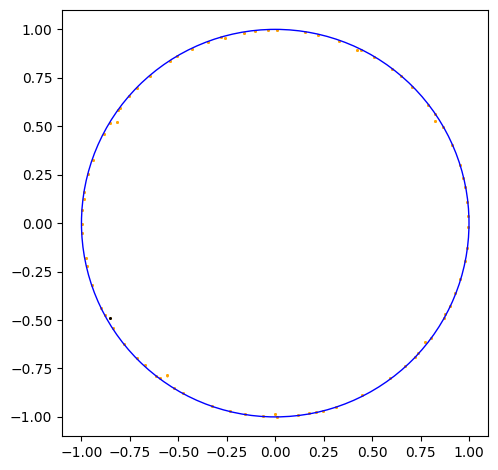

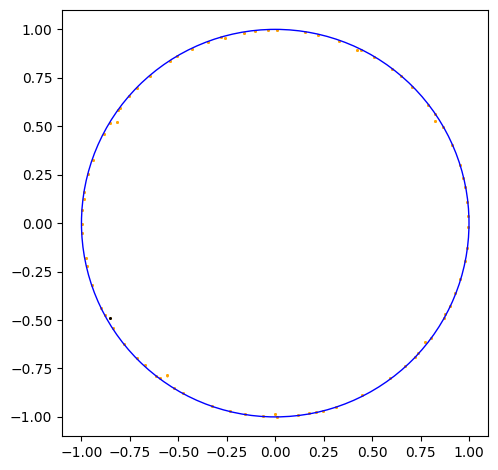

In [36]:
# Run experiments
for (cf, correct_grad, exact_grad) in experiment_details:
    print(f"[Experiment: {exp_id}] \t cf: {cf.class_str()}, correct grad: {correct_grad},  exact grad: {exact_grad}")
    
    # (1) Compute initial embedding in Poincare disk (PCA embedding)
    X_embedded = initialization(
        n_samples=D.shape[0], 
        n_components=2,
        X=None,
        random_state=seed,
        method="random",
        init_scale=1e-4         # spread out initializations more
    ) 

    # Initialize config and parameters
    if cf == GaussianKL:
        learning_rate = D.shape[0] / (exaggeration_factor * 10) * hyp_var

    # NOTE: Change lr. depending on wrong/correct HyperbolicKL
    elif cf == HyperbolicKL:
        learning_rate = D.shape[0] / (exaggeration_factor * 100)

    print(f"The learning rate is: {learning_rate}")

    no_progr_its = (ex_iterations + main_iterations) / 3        # nr. of iterations of no progress before we stop

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, 
                          exact=exact_grad, vanilla=True, grad_scale_fix=grad_scale_fix, 
                          grad_fix=correct_grad, size_tol=size_tol, max_no_progress=no_progr_its)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

    log_path_cf = log_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"
    grad_path_grad = grad_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"

    # (3) Update config params using computed variance
    opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use
    
    # Only add var as param for GaussianKL
    if cf == GaussianKL:
        opt_params["cf_params"].update({"var" : hyp_var})                  # GaussianKL variance for q_ij

    # (4) Set up t-SNE object and run
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed",
        verbose=1, 
        opt_method=SequentialOptimizer,         # the optimizater we use
        opt_params=opt_params              # the parameters for the optimizers
        )

    # Compute embedding:
    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
        
    except ValueError:
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()

    # (5) Plot the embedding (NOTE: We can also use plot_poincare)
    # emb_fig = plot_poincare(hyperbolicEmbedding, dataLabels)
    emb_fig = plot_tree(hyperbolicEmbedding, dataLabels)

    # (6) Store experiment results
    # folder to save results to
    save_folder = f"./experiment_results/experiment_{exp_id}/"   

    # dictionary containing relevant details of this experiment
    optim_procedure = "Vanilla SGD"
    description = "Wrong gradient, tree data experiment with HyperbolicKL. More iterations, larger lr."
    
    if cf == GaussianKL:
        exp_data = GaussianKL_Tree_results(n_children, depth, cluster_size, dist, n_nodes, htsne, ex_iterations,
                                            main_iterations, cf, hyp_var, size_tol, max_dist_H, max_dist,
                                            correct_grad, grad_scale_fix, exact_grad, exaggeration_factor, 
                                            optim_procedure, description)
    elif cf == HyperbolicKL:
        exp_data = HyperbolicKL_Tree_results(n_children, depth, cluster_size, dist, n_nodes, htsne, ex_iterations,
                                             main_iterations, cf, correct_grad, grad_scale_fix, exact_grad, exaggeration_factor, 
                                             optim_procedure, description)
    
    # Prepare index for next iteration
    exp_id += 1    
 
    animation_step = 25
    save_experiment_results(save_folder, None, emb_fig, opt_params, dataLabels, 
                            exp_data, hyperbolicEmbedding, animation_step)